# Target Ensemble

Apart from the main target, there are actually many auxilliary targets in the dataset.

These targets are fundamentally related to the main target which make them potentially helpful to model. And because these targets have a wide range of correlations to the main targets, it means that we could potentially build some nice ensembles to boost our performance.

In this notebook, we will
1. Explore the auxilliary targets
2. Select our favorite targets to include in the ensemble
3. Create an ensemble of models trained on different targets
4. Pickle and upload our ensemble model

In [ ]:
# Install dependencies
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle seaborn scipy==1.10.1

# Inline plots
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 26.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


## 1. Auxilliary Targets

Let's start by taking a look at the different targets in the training data.

In [ ]:
import pandas as pd
import json
from numerapi import NumerAPI

# Set the data version to one of the most recent versions
DATA_VERSION = "v4.3"

# Download data
napi = NumerAPI()
napi.download_dataset(f"{DATA_VERSION}/train_int8.parquet");
napi.download_dataset(f"{DATA_VERSION}/features.json");

# Load data
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
feature_cols = feature_metadata["feature_sets"]["medium"]
target_cols = feature_metadata["targets"]
train = pd.read_parquet(
    f"{DATA_VERSION}/train_int8.parquet",
    columns=["era"] + feature_cols + target_cols
)

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data (higher memory usage, slower model training, potentially better performance)
train = train[train["era"].isin(train["era"].unique()[::4])]

# Print target columns
train[["era"] + target_cols]

v4.2/train_int8.parquet: 1.89GB [06:13, 5.06MB/s]                            
v4.2/features.json: 1.03MB [00:00, 3.33MB/s]                           


,era,target,target_nomi_v4_20,target_nomi_v4_60,target_tyler_v4_20,target_tyler_v4_60,target_victor_v4_20,target_victor_v4_60,target_ralph_v4_20,target_ralph_v4_60,...,target_jeremy_v4_20,target_jeremy_v4_60,target_teager_v4_20,target_teager_v4_60,target_agnes_v4_20,target_agnes_v4_60,target_claudia_v4_20,target_claudia_v4_60,target_rowan_v4_20,target_rowan_v4_60
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,0.25,0.25,0.00,0.50,0.25,0.25,0.00,0.25,0.25,...,0.25,0.25,0.50,0.75,0.25,0.00,0.50,0.50,0.50,0.75
n003bee128c2fcfc,0001,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,...,0.75,1.00,1.00,0.75,1.00,1.00,1.00,0.75,1.00,0.75
n0048ac83aff7194,0001,0.25,0.50,0.25,0.50,0.50,0.50,0.25,0.50,0.25,...,0.50,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
n00691bec80d3e02,0001,0.75,0.75,0.50,0.50,0.75,0.75,0.50,0.75,0.50,...,0.50,0.50,0.75,0.75,0.50,0.50,0.75,0.75,0.75,0.50
n00b8720a2fdc4f2,0001,0.50,0.75,0.50,0.75,0.75,0.75,0.50,0.50,0.50,...,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffc2d5e4b79a7ae,0573,0.25,0.25,0.50,0.25,0.50,0.25,0.50,0.25,0.50,...,0.00,0.25,0.00,0.25,0.00,0.50,0.25,0.50,0.00,0.25
nffc7d24176548a4,0573,0.50,0.50,0.25,0.50,0.25,0.50,0.50,0.50,0.25,...,0.50,0.25,0.50,0.50,0.50,0.25,0.50,0.25,0.25,0.50
nffc9844c1c7a6a9,0573,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.25,0.50,...,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.25,0.75


### The main target

First thing to note is that `target` is just an alias for `target_cyrus_v4_20`, so we can drop this column for the rest of the notebook.

In [ ]:
# Drop `target` column
assert train["target"].equals(train["target_cyrus_v4_20"])
target_names = target_cols[1:]
targets_df = train[["era"] + target_names]

### Target names

At a high level, each target represents a different kind of stock market return
- the `name` represents the type of stock market return (eg. residual to market/country/sector vs market/country/style)
- the `_20` or `_60` suffix denotes the time horizon of the target (ie. 20 vs 60 market days)

The reason why `target_cyrus_v4_20` is our main target is because it most closely matches the type of returns we want for our hedge fund. Just like how we are always in search for better features to include in the dataset, we are also always in search for better targets to make our main target. During our research, we often come up with targets we like but not as much as the main target, and these are instead released as auxilliary targets.

In [ ]:
# Print target names grouped by name and time horizon
pd.set_option('display.max_rows', 100)
t20s = [t for t in target_names if t.endswith("_20")]
t60s = [t for t in target_names if t.endswith("_60")]
names = [t[7:-6] for t in t20s]
pd.DataFrame({"name": names,"20": t20s,"60": t60s}).set_index("name")

,20,60
name,,
nomi,target_nomi_v4_20,target_nomi_v4_60
tyler,target_tyler_v4_20,target_tyler_v4_60
victor,target_victor_v4_20,target_victor_v4_60
ralph,target_ralph_v4_20,target_ralph_v4_60
waldo,target_waldo_v4_20,target_waldo_v4_60
jerome,target_jerome_v4_20,target_jerome_v4_60
janet,target_janet_v4_20,target_janet_v4_60
ben,target_ben_v4_20,target_ben_v4_60
alan,target_alan_v4_20,target_alan_v4_60


### Target values

Note that some targets are binned into 5 bins while others are binned into 7 bins.

Unlike feature values which are integers ranging from 0-4, target values are floats which range from 0-1.

array([[<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>]],
      dtype=object)

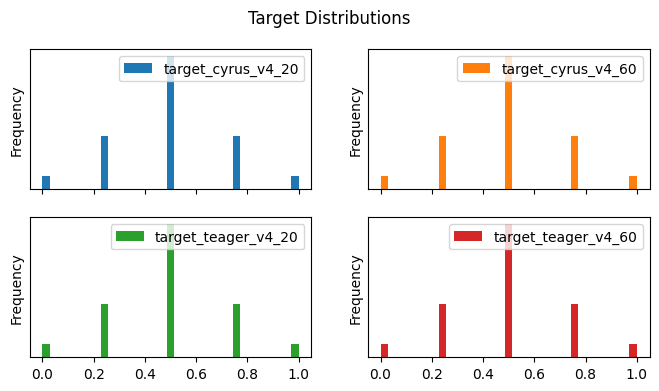

In [ ]:
# Plot target distributions
targets_df[[
  "target_cyrus_v4_20",
  "target_cyrus_v4_60",
  "target_teager_v4_20",
  "target_teager_v4_60"
]].plot(
  title="Target Distributions",
  kind="hist",
  bins=35,
  density=True,
  figsize=(8, 4),
  subplots=True,
  layout=(2, 2),
  ylabel="",
  yticks=[]
)

It is also important to note that the auxilary targets can be `NaN`, but the primary target will never be `NaN`. Since we are using tree-based models here we won't need to do any special pre-processing.

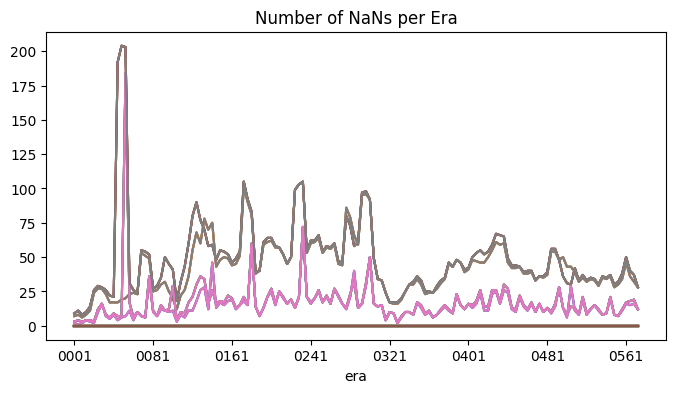

In [ ]:
# print number of NaNs per era
nans_per_era = targets_df.groupby("era").apply(lambda x: x.isna().sum())
nans_per_era[target_names].plot(figsize=(8, 4), title="Number of NaNs per Era", legend=False);

### Target correlations

The targets have a wide range of correlations with each other even though they are all fundamentally related, which should allow the construction of diverse models that ensemble together nicely.

<Axes: >

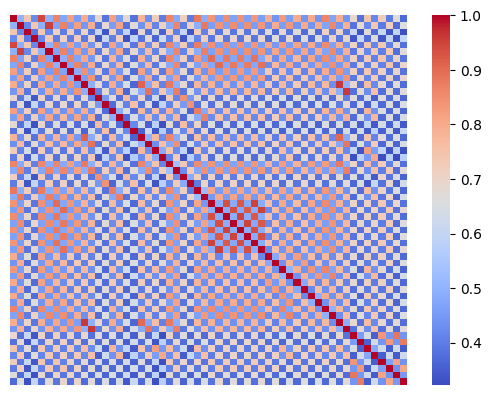

In [ ]:
# Plot correlation matrix of targets
import seaborn as sns
sns.heatmap(
  targets_df[target_names].corr(),
  cmap="coolwarm",
  xticklabels=False,
  yticklabels=False
)

Since we are ultimately trying to predict the main target (`target_cyrus_v4_20`), it is perhaps most important to consider each auxilliary target's correlation to it.

In [ ]:
(
    targets_df[target_names]
    .corrwith(targets_df["target_cyrus_v4_20"])
    .sort_values(ascending=False)
    .to_frame("corr_with_cyrus_v4_20")
)

,corr_with_cyrus_v4_20
target_cyrus_v4_20,1.000000
target_xerxes_v4_20,0.951474
target_caroline_v4_20,0.938870
target_sam_v4_20,0.923488
target_ralph_v4_20,0.898095
target_echo_v4_20,0.853768
target_victor_v4_20,0.841411
target_nomi_v4_20,0.840038
target_william_v4_20,0.837671
target_waldo_v4_20,0.833776


## 2. Target Selection

Our goal is to create an ensemble of models trained on different targets. But which targets should we use?

When deciding which model to ensemble, we should consider a few things:

- The performance of the predictions of the model trained on the target vs the main target

- The correlation between the target and the main target

To keep things simple and fast, let's just arbitrarily pick a few 20-day targets to evaluate.

In [ ]:
# pick a few 20-day target candidates
target_candidates = [
  "target_cyrus_v4_20",
  "target_victor_v4_20",
  "target_xerxes_v4_20",
  "target_teager_v4_20"
]

### Model training and generating validation predictions

Like usual we train on the training dataset, but this time we do it for each target.

Sit back and relax, this will take a while
# ☕

In [ ]:
import lightgbm as lgb

models = {}
for target in target_candidates:
    model = lgb.LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=5,
        num_leaves=2**4-1,
        colsample_bytree=0.1
    )
    model.fit(
        train[feature_cols],
        train[target]
    );
    models[target] = model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2915
[LightGBM] [Info] Number of data points in the train set: 606176, number of used features: 583
[LightGBM] [Info] Start training from score 0.499979
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2915
[LightGBM] [Info] Number of data points in the train set: 606176, number of used features: 583
[LightGBM] [Info] Start training from score 0.500008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

Then we will generate predictions on the validation dataset.

In [ ]:
# Download validation data
napi.download_dataset(f"{DATA_VERSION}/validation_int8.parquet");

# Load the validation data, filtering for data_type == "validation"
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation_int8.parquet",
    columns=["era", "data_type"] + feature_cols + target_cols
)
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample every 4th era to reduce memory usage and speedup validation (suggested for Colab free tier)
# Comment out the line below to use all the data
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Embargo overlapping eras from training data
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

# Generate validation predictions for each model
for target in target_candidates:
    validation[f"prediction_{target}"] = models[target].predict(validation[feature_cols])

pred_cols = [f"prediction_{target}" for target in target_candidates]
validation[pred_cols]

v4.2/validation_int8.parquet: 2.22GB [05:50, 6.33MB/s]                            


,prediction_target_cyrus_v4_20,prediction_target_victor_v4_20,prediction_target_xerxes_v4_20,prediction_target_teager_v4_20
id,,,,
n002a15bc5575bbb,0.504974,0.499295,0.505556,0.499106
n00309caaa0f955e,0.506363,0.510746,0.503826,0.503030
n00576b397182463,0.496452,0.496656,0.498337,0.501940
n00633405d59c6a1,0.508857,0.502036,0.504053,0.506346
n008c2eefc8911c7,0.494301,0.496588,0.494579,0.493595
...,...,...,...,...
nffb595755a1cc08,0.493951,0.495661,0.492211,0.503113
nffb98fa8c9ed68c,0.490607,0.494598,0.493429,0.494693
nffd0563de794063,0.498027,0.494445,0.497446,0.493063


### Evaluating the performance of each model

Now we can evaluate the performance of our models.

In [ ]:
# install Numerai's open-source scoring tools
!pip install -q --no-deps numerai-tools

# import the 2 scoring functions
from numerai_tools.scoring import numerai_corr, correlation_contribution

As you can see in the performance chart below, models trained on the auxiliary target are able to predict the main target pretty well, but the model trained on the main target performs the best.

<Axes: title={'center': 'Cumulative Correlation of validation Predictions'}, xlabel='era'>

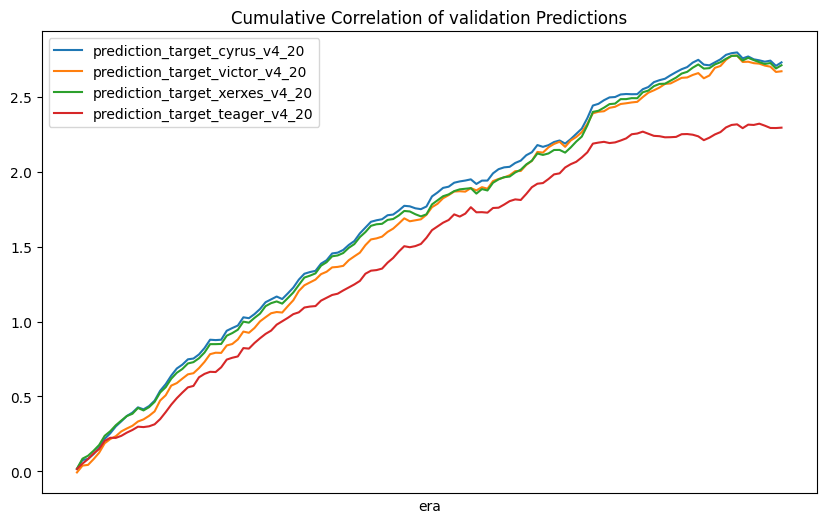

In [ ]:
prediction_cols = [
    f"prediction_{target}"
    for target in target_candidates
]
correlations = validation.groupby("era").apply(
    lambda d: numerai_corr(d[prediction_cols], d["target"])
)
cumsum_corrs = correlations.cumsum()
cumsum_corrs.plot(
  title="Cumulative Correlation of validation Predictions",
  figsize=(10, 6),
  xticks=[]
)

Looking at the summary metrics below:
- the models trained on `victor` and `xerxes` have the highest means, but `victor` is less correlated with `cyrus` than `xerxes` is, which means `victor` could be better in ensembling
- the model trained on `teager` has the lowest mean, but `teager` is significantly less correlated with `cyrus` than any other target shown

In [ ]:
def get_summary_metrics(scores, cumsum_scores):
    summary_metrics = {}
    # per era correlation between predictions of the model trained on this target and cyrus
    mean = scores.mean()
    std = scores.std()
    sharpe = mean / std
    rolling_max = cumsum_scores.expanding(min_periods=1).max()
    max_drawdown = (rolling_max - cumsum_scores).max()
    return {
        "mean": mean,
        "std": std,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
    }

target_summary_metrics = {}
for pred_col in prediction_cols:
  target_summary_metrics[pred_col] = get_summary_metrics(
      correlations[pred_col], cumsum_corrs[pred_col]
  )
  # per era correlation between this target and cyrus
  mean_corr_with_cryus = validation.groupby("era").apply(
      lambda d: d[target].corr(d["target_cyrus_v4_20"])
  ).mean()
  target_summary_metrics[pred_col].update({
      "mean_corr_with_cryus": mean_corr_with_cryus
  })


pd.set_option('display.float_format', lambda x: '%f' % x)
summary = pd.DataFrame(target_summary_metrics).T
summary

,mean,std,sharpe,max_drawdown,mean_corr_with_cryus
prediction_target_cyrus_v4_20,0.021339,0.022375,0.953736,0.089516,0.706184
prediction_target_victor_v4_20,0.020875,0.021560,0.968241,0.109370,0.706184
prediction_target_xerxes_v4_20,0.021189,0.022616,0.936933,0.085392,0.706184
prediction_target_teager_v4_20,0.017932,0.018759,0.955922,0.056967,0.706184


### Selecting our favorite target
Based on our observations above, it seems like target `victor` is the best candidate target for our ensemble since it has great performance and it is not too correlated with `cyrus`. However, it's interesting to look at how models that are very uncorrelated ensemble together; we are going to also look at how `teager` ensembles with `cyrus`.

What do you think?

Note that this target selection heuristic is extremely basic. In your own research, you will most likely want to consider all targets instead of just our favorites, and may want to experiment with different ways of selecting your ensemble targets.

## 3. Ensembling

Now that we have reviewed and selected our favorite targets, let's ensemble our predictions and re-evaluate performance.

### Creating the ensemble

For simplicity, we will equal weight the predictions from target `victor` and `cyrus`. Note that this is an extremely basic and arbitrary way of selecting ensemble weights. In your research, you may want to experiment with different ways of setting ensemble weights.

Tip: remember to always normalize (percentile rank) your predictions before averaging so that they are comparable!

In [ ]:
# Ensemble predictions together with a simple average
validation["ensemble_cyrus_victor"] = (
    validation
    .groupby("era")[[
      "prediction_target_cyrus_v4_20",
      "prediction_target_victor_v4_20",
    ]]
    .rank(pct=True)
    .mean(axis=1)
)
validation["ensemble_cyrus_teager"] = (
    validation
    .groupby("era")[[
      "prediction_target_cyrus_v4_20",
      "prediction_target_teager_v4_20",
    ]]
    .rank(pct=True)
    .mean(axis=1)
)

# Print the ensemble predictions
prediction_cols = [
  "prediction_target_cyrus_v4_20",
  "prediction_target_victor_v4_20",
  "prediction_target_teager_v4_20",
  "ensemble_cyrus_victor",
  "ensemble_cyrus_teager"
]
validation[prediction_cols]

<ipython-input-31-2ddd43bf51f3>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  validation
<ipython-input-31-2ddd43bf51f3>:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  validation


,prediction_target_cyrus_v4_20,prediction_target_victor_v4_20,prediction_target_teager_v4_20,ensemble_cyrus_victor,ensemble_cyrus_teager
id,,,,,
n002a15bc5575bbb,0.504974,0.499295,0.499106,0.592906,0.571974
n00309caaa0f955e,0.506363,0.510746,0.503030,0.843060,0.759744
n00576b397182463,0.496452,0.496656,0.501940,0.317282,0.497216
n00633405d59c6a1,0.508857,0.502036,0.506346,0.734584,0.871004
n008c2eefc8911c7,0.494301,0.496588,0.493595,0.267890,0.155908
...,...,...,...,...,...
nffb595755a1cc08,0.493951,0.495661,0.503113,0.272955,0.512027
nffb98fa8c9ed68c,0.490607,0.494598,0.494693,0.195357,0.142648
nffd0563de794063,0.498027,0.494445,0.493063,0.332671,0.254236


### Evaluating performance of the ensemble
Looking at the performance chart below, we can see that the peformance of our ensembles are better than that of the models trained on individual targets. Is this a result you would have expected or does it surprise you?

<Axes: title={'center': 'Cumulative Correlation of validation Predictions'}, xlabel='era'>

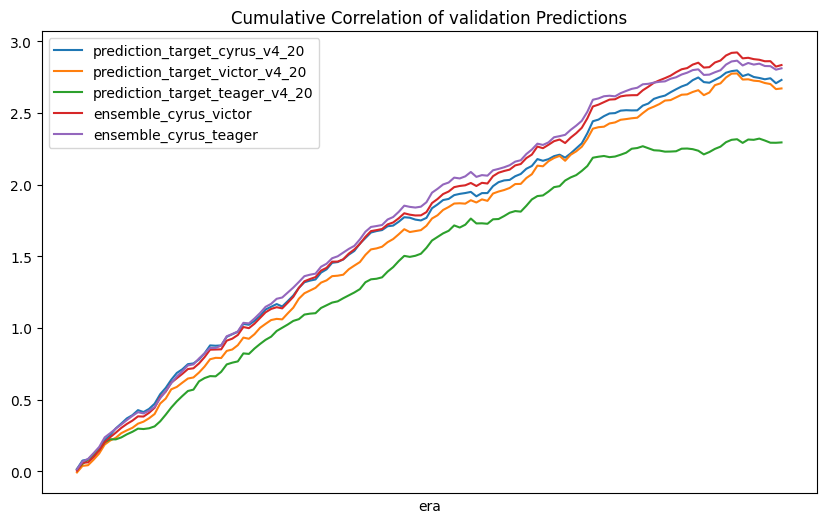

In [ ]:
correlations = validation.groupby("era").apply(
    lambda d: numerai_corr(d[prediction_cols], d["target"])
)
cumsum_corrs = correlations.cumsum()

cumsum_corrs = pd.DataFrame(cumsum_corrs)
cumsum_corrs.plot(
    title="Cumulative Correlation of validation Predictions",
    figsize=(10, 6),
    xticks=[]
)

Looking at the summary metrics below, we can see that our ensemble seems to have better `mean`, `sharpe`, and `max_drawdown` than our original model. Much more interestingly, however, is that our ensemble with `teager` has even higher sharpe than the ensemble with `victor`!

In [ ]:
summary_metrics = get_summary_metrics(correlations, cumsum_corrs)
pd.set_option('display.float_format', lambda x: '%f' % x)
summary = pd.DataFrame(summary_metrics)
summary

,mean,std,sharpe,max_drawdown
prediction_target_cyrus_v4_20,0.021339,0.022375,0.953736,0.089516
prediction_target_victor_v4_20,0.020875,0.021560,0.968241,0.109370
prediction_target_teager_v4_20,0.017932,0.018759,0.955922,0.056967
ensemble_cyrus_victor,0.022151,0.022177,0.998799,0.098793
ensemble_cyrus_teager,0.021974,0.021175,1.037726,0.062877


You can see below that `teager` also improves MMC performance significantly.

,mean,std,sharpe,max_drawdown
prediction_target_cyrus_v4_20,0.002379,0.012263,0.193971,0.065042
prediction_target_victor_v4_20,0.003434,0.014676,0.234010,0.058050
prediction_target_teager_v4_20,0.004341,0.014369,0.302131,0.126459
ensemble_cyrus_victor,0.003036,0.012972,0.234046,0.061129
ensemble_cyrus_teager,0.003886,0.012496,0.310991,0.081644


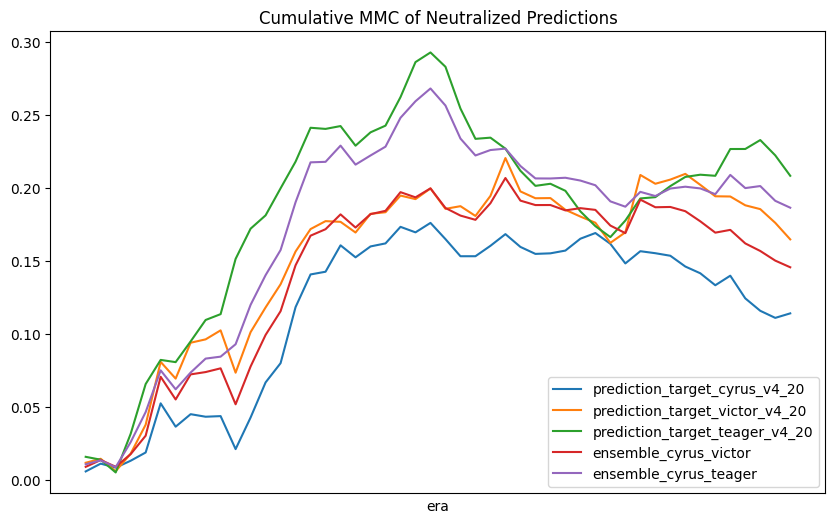

In [ ]:
from numerai_tools.scoring import correlation_contribution

# Download and join in the meta_model for the validation eras
napi.download_dataset(f"{DATA_VERSION}/meta_model.parquet")
validation["meta_model"] = pd.read_parquet(
    f"{DATA_VERSION}/meta_model.parquet"
)["numerai_meta_model"]

def get_mmc(validation, meta_model_col):
    # Compute the per-era mmc between our predictions, the meta model, and the target values
    per_era_mmc = validation.dropna().groupby("era").apply(
        lambda x: correlation_contribution(
            x[prediction_cols], x[meta_model_col], x["target"]
        )
    )

    cumsum_mmc = per_era_mmc.cumsum()

    # compute summary metrics
    summary_metrics = get_summary_metrics(per_era_mmc, cumsum_mmc)
    summary = pd.DataFrame(summary_metrics)

    return per_era_mmc, cumsum_mmc, summary

per_era_mmc, cumsum_mmc, summary = get_mmc(validation, "meta_model")
# plot the cumsum mmc performance
cumsum_mmc.plot(
  title="Cumulative MMC of Neutralized Predictions",
  figsize=(10, 6),
  xticks=[]
)

pd.set_option('display.float_format', lambda x: '%f' % x)
summary

#### Benchmark Models

It's no accident that a model trained on `teager` ensembles so well. We have seen in our research that models trained or ensembled using `teager` perform extremely well. We even released a benchmark for a [teager ensemble](https://numer.ai/v42_teager_ensemble). We submit predictions for all internally known models [here](https://numer.ai/~benchmark_models) and release files with their predictions.

In [ ]:
# download Numerai's benchmark models
napi.download_dataset(f"{DATA_VERSION}/validation_benchmark_models.parquet")
benchmark_models = pd.read_parquet(
    f"{DATA_VERSION}/validation_benchmark_models.parquet"
)
benchmark_models

,era,v42_example_preds,v42_lgbm_teager60,v42_lgbm_teager20,v42_lgbm_agnes20,v42_lgbm_claudia20,v42_lgbm_rowan20,v41_lgbm_xerxes60,v41_lgbm_xerxes20,v41_lgbm_sam60,...,v4_lgbm_nomi60,v4_lgbm_nomi20,v4_lgbm_jerome60,v4_lgbm_jerome20,v3_example_preds,v2_example_preds,v41_example_preds,v42_rain_ensemble,v42_rain_ensemble2,v42_teager_plus_cyrus
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,0.122215,0.226733,0.127629,0.290235,0.054966,0.170102,0.796169,0.604622,0.744535,...,0.373517,0.397876,0.805746,0.496148,0.231938,0.616698,0.353321,0.131168,0.062045,0.105143
n001e1318d5072ac,0575,0.624193,0.318551,0.493650,0.960025,0.479492,0.564647,0.367479,0.650843,0.407870,...,0.158443,0.367687,0.513429,0.499479,0.549240,0.632313,0.443056,0.569436,0.605663,0.572975
n002a9c5ab785cbb,0575,0.533417,0.895274,0.897564,0.422236,0.905892,0.934208,0.359567,0.350198,0.363523,...,0.546950,0.479284,0.746617,0.413908,0.343743,0.521549,0.450552,0.634395,0.484072,0.769727
n002ccf6d0e8c5ad,0575,0.955445,0.978139,0.989798,0.987716,0.985009,0.990839,0.956277,0.958359,0.926296,...,0.947325,0.943993,0.867583,0.890069,0.953362,0.884447,0.969602,0.977306,0.966271,0.981262
n0051ab821295c29,0575,0.075161,0.156777,0.252967,0.120341,0.280242,0.251509,0.113679,0.076411,0.073079,...,0.040808,0.078701,0.096814,0.079325,0.462211,0.078493,0.239017,0.064335,0.164689,0.126588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffda39067634e48,1092,0.048115,0.433243,0.612997,0.299104,0.536555,0.617580,0.100396,0.108936,0.140179,...,0.269111,0.260779,0.740054,0.652156,0.184961,0.297646,0.333680,0.113726,0.173922,0.230994
nffde55ab10aa0b0,1092,0.899396,0.368881,0.488856,0.721933,0.414289,0.405124,0.888981,0.955843,0.876276,...,0.758175,0.851281,0.264112,0.524682,0.433868,0.731098,0.858155,0.807540,0.730681,0.754634
nffe4e3d32278c89,1092,0.593210,0.619038,0.823578,0.575297,0.858363,0.747136,0.301604,0.527807,0.263070,...,0.189960,0.167465,0.325141,0.332431,0.551968,0.509894,0.729848,0.614872,0.582379,0.737138


Because models trained on newer targets perform so well and we release their predictions, it's likely many users will begin to shift their models to include newer data and targets. By extension, the Meta Model will begin to include information from from these new targets.

This means that MMC over the validation period may not be truly indicative of out-of-sample performance. The Meta Model over the early validation period did not have access to newer data/targets and MMC over the validation period may be misleading.

So if the Meta Model was much closer to our teager ensemble, what would your MMC look like?

,mean,std,sharpe,max_drawdown
prediction_target_cyrus_v4_20,-0.000445,0.013495,-0.032988,0.079499
prediction_target_victor_v4_20,-0.000023,0.015269,-0.001521,0.081976
prediction_target_xerxes_v4_20,0.000892,0.013967,0.063863,0.066099
prediction_target_teager_v4_20,-0.001942,0.013055,-0.148774,0.182975


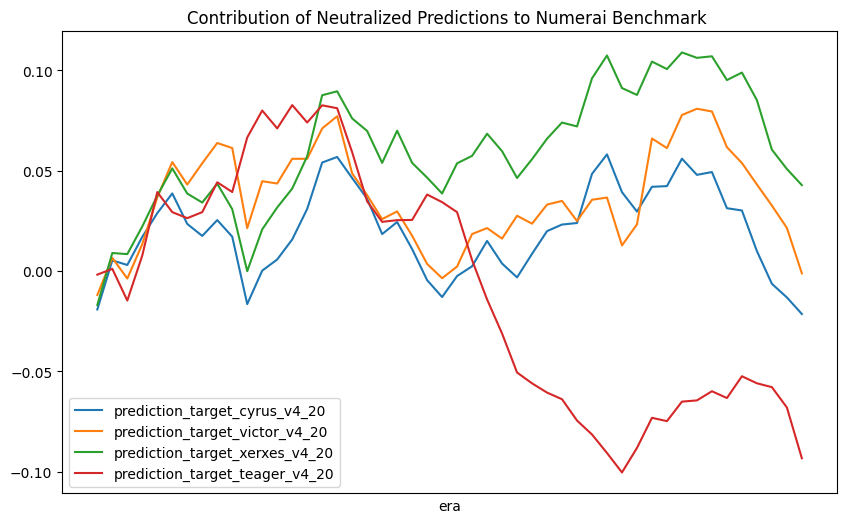

In [ ]:
validation["v42_teager_plus_cyrus"] = benchmark_models["v42_teager_plus_cyrus"]


per_era_mmc, cumsum_mmc, summary = get_mmc(validation, "v42_teager_plus_cyrus")
# plot the cumsum mmc performance
cumsum_mmc.plot(
  title="Contribution of Neutralized Predictions to Numerai's Teager Ensemble",
  figsize=(10, 6),
  xticks=[]
)

pd.set_option('display.float_format', lambda x: '%f' % x)
summary

Ouch. Our teager models actually perform the worst. This means we aren't adding very useful signal to a model that Numerai already created, but this should not be surprising since we are training basically the same model. The model trained with `xerxes`, however, still does well against Numerai's model. What do you think this means?

It's also helpful to if we measured the contribution of your models to all of Numerai's benchmark models. We call this Benchmark Model Contribution or `BMC`.  On the website, `BMC` measures your model's contribution to a weighted ensemble of all of our Benchmark Models.

This is an important metric to track because it tells you how additive your model is to Numerai's known models and, by extension, how additive you might be to the Meta Model in the future.

To keep things simple, we will use an unweighted ensemble of Numerai's Benchmarks to measure your models' BMC, let's take a look:

<ipython-input-35-a474e4cb0ab1>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  .apply(lambda x: x.mean(axis=1))


,mean,std,sharpe,max_drawdown
prediction_target_cyrus_v4_20,-0.002647,0.010627,-0.249073,0.161432
prediction_target_victor_v4_20,-0.001774,0.013619,-0.130238,0.151790
prediction_target_teager_v4_20,-0.000957,0.014051,-0.068099,0.204173
ensemble_cyrus_victor,-0.002329,0.011520,-0.202137,0.168824
ensemble_cyrus_teager,-0.002000,0.010922,-0.183158,0.187705


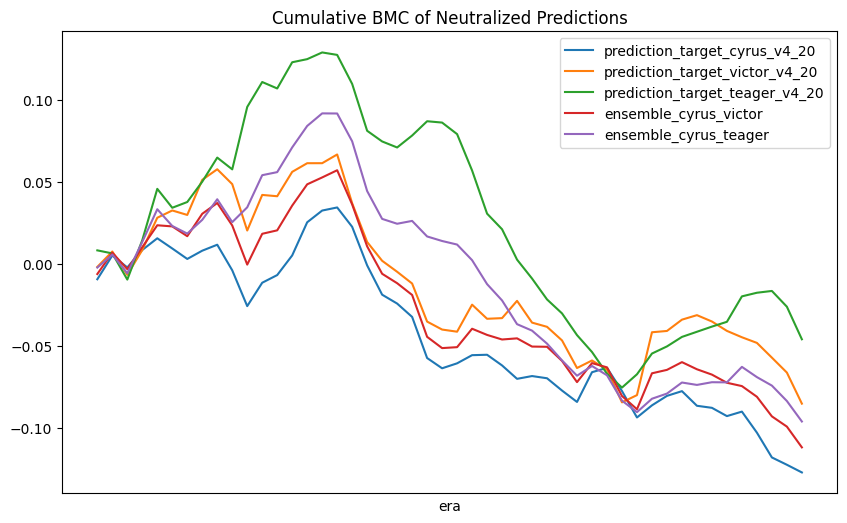

In [ ]:
validation["numerai_benchmark"] = (
    benchmark_models
    .groupby("era")
    .apply(lambda x: x.mean(axis=1))
    .reset_index()
    .set_index("id")[0]
)

per_era_mmc, cumsum_mmc, summary = get_mmc(validation, "numerai_benchmark")
# plot the cumsum mmc performance
cumsum_mmc.plot(
  title="Cumulative BMC of Neutralized Predictions",
  figsize=(10, 6),
  xticks=[]
)

pd.set_option('display.float_format', lambda x: '%f' % x)
summary

Looking at the results above, none of these models seem very additive to models that Numerai can already create. It will take some research and experimentation to find something additive to Numerai's benchmarks.

Ensembling models trained on different targets can be a very fruitful avenue of research. However, it is completely up to you whether or not to create an ensemble - there are many great performing models that don't make use of the auxilliary targets at all.

If you are interested in learning more about targets, we highly encourage you to read up on these forum posts
- https://forum.numer.ai/t/how-to-ensemble-models/4034
- https://forum.numer.ai/t/target-jerome-is-dominating-and-thats-weird/6513

## 4. Model Upload
To wrap up this notebook, let's pickle and upload our ensemble.

As usual, we will be wrapping our submission pipeline into a function. Since we already have our favorite targets and trained models in memory, we can simply reference them in our function.  

In [ ]:
# we now give you access to the live_benchmark_models if you want to use them in your ensemble
def predict_ensemble(
    live_features: pd.DataFrame,
    live_benchmark_models: pd.DataFrame
) -> pd.DataFrame:
    favorite_targets = [
        'target_cyrus_v4_20',
        'target_teager_v4_20'
    ]
    # generate predictions from each model
    predictions = pd.DataFrame(index=live_features.index)
    for target in favorite_targets:
        predictions[target] = models[target].predict(live_features[feature_cols])
    # ensemble predictions
    ensemble = predictions.rank(pct=True).mean(axis=1)
    # format submission
    submission = ensemble.rank(pct=True, method="first")
    return submission.to_frame("prediction")

In [ ]:
# Quick test
napi.download_dataset(f"{DATA_VERSION}/live_int8.parquet")
live_features = pd.read_parquet(f"{DATA_VERSION}/live_int8.parquet", columns=feature_cols)
predict_ensemble(live_features)

,prediction
id,
n003220654a68812,0.750775
n00352c3e7c0aa55,0.808845
n0076d55b498b331,0.463939
n0077c5d64c1c3d1,0.900393
n00788f6b7bff09a,0.833437
...,...
nffccd79b58a69c5,0.630709
nffd9524f1aae16a,0.453399
nffdef0dd22e7e64,0.116140


In [ ]:
# Use the cloudpickle library to serialize your function and its dependencies
import cloudpickle
p = cloudpickle.dumps(predict_ensemble)
with open("predict_ensemble.pkl", "wb") as f:
    f.write(p)

In [ ]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('predict_ensemble.pkl')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

That's it! Now head back to [numer.ai](numer.ai) to upload your model!